#ENTREGA MÓDULOS APRENDIZAJE PROFUNDO I Y II
### MÁSTER EN INTELIGENCIA ARTIFICIAL AVANZADA Y APLICADA 
#### Quique García Vidal

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import random
import tensorflow_hub as hub
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
import tensorflow
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG, display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense,InputLayer
from keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from matplotlib.ticker import MaxNLocator
from os import walk
from tqdm import tqdm

# 1. Detección de puntos faciales clave (imágenes con 1 canal): CNN

### Importar datos:

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
facialDF = pd.read_csv('/content/drive/MyDrive/Emotion AI Dataset/data.csv')

#### Transformar datos a int y reshape a 96 x 96 (entrada del modelo)

In [ ]:
facialDF['Image'] = facialDF['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

#### Cambiar brillo de las imágenes:

In [ ]:
facialDF['Image'] = facialDF['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))

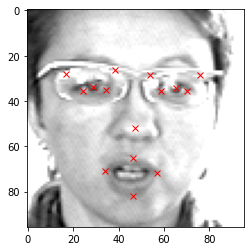

In [ ]:
plt.imshow(facialDF['Image'][10], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialDF.loc[10][j-1], facialDF.loc[10][j], 'rx')

#### Separar datos en X y Y:

In [ ]:
img = facialDF.iloc[:,30]
img = img/255.

X = np.empty((len(img), 96, 96,1))

for i in range(len(img)):
  X[i,:,:,0] = img[i]
X = np.asarray(X).astype(np.float32)
X.shape

(2140, 96, 96, 1)

In [ ]:
y = facialDF.iloc[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(2140, 30)

#### Dividir en train y test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### Función de visualización gráficas de entrenamiento:

In [ ]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
def bloqueResNet(X, filter, stage):

  # Bloque Convolucional
  X_copy = X

  f1 , f2, f3 = filter

  # Camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3)(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same')(X)
  X = BatchNormalization(axis =3)(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1))(X)
  X = BatchNormalization(axis =3)(X)


  # Camino Corto
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3)(X_copy)

  # Añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Bloque de Identidad 1
  X_copy = X


  # Camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1))(X)
  X = BatchNormalization(axis =3)(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same')(X)
  X = BatchNormalization(axis =3)(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1))(X)
  X = BatchNormalization(axis =3)(X)

  # Añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Bloque de Identidad 2
  X_copy = X


  # Camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1))(X)
  X = BatchNormalization(axis =3)(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same')(X)
  X = BatchNormalization(axis =3)(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1))(X)
  X = BatchNormalization(axis =3)(X)

  # Añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

## A) Modelo con 1 bloque Residual

### Definición del modelo:

In [ ]:
input_shape = (96, 96, 1)

# Tamaño del tensor de entrada
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - Fase
X = Conv2D(64, (7,7), strides= (2,2))(X)
X = BatchNormalization(axis =3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

#Residual block 1
X = bloqueResNet(X, filter= [64,64,256], stage= 2)

# Average Pooling
X = AveragePooling2D((2,2))(X)

# Capa Final
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

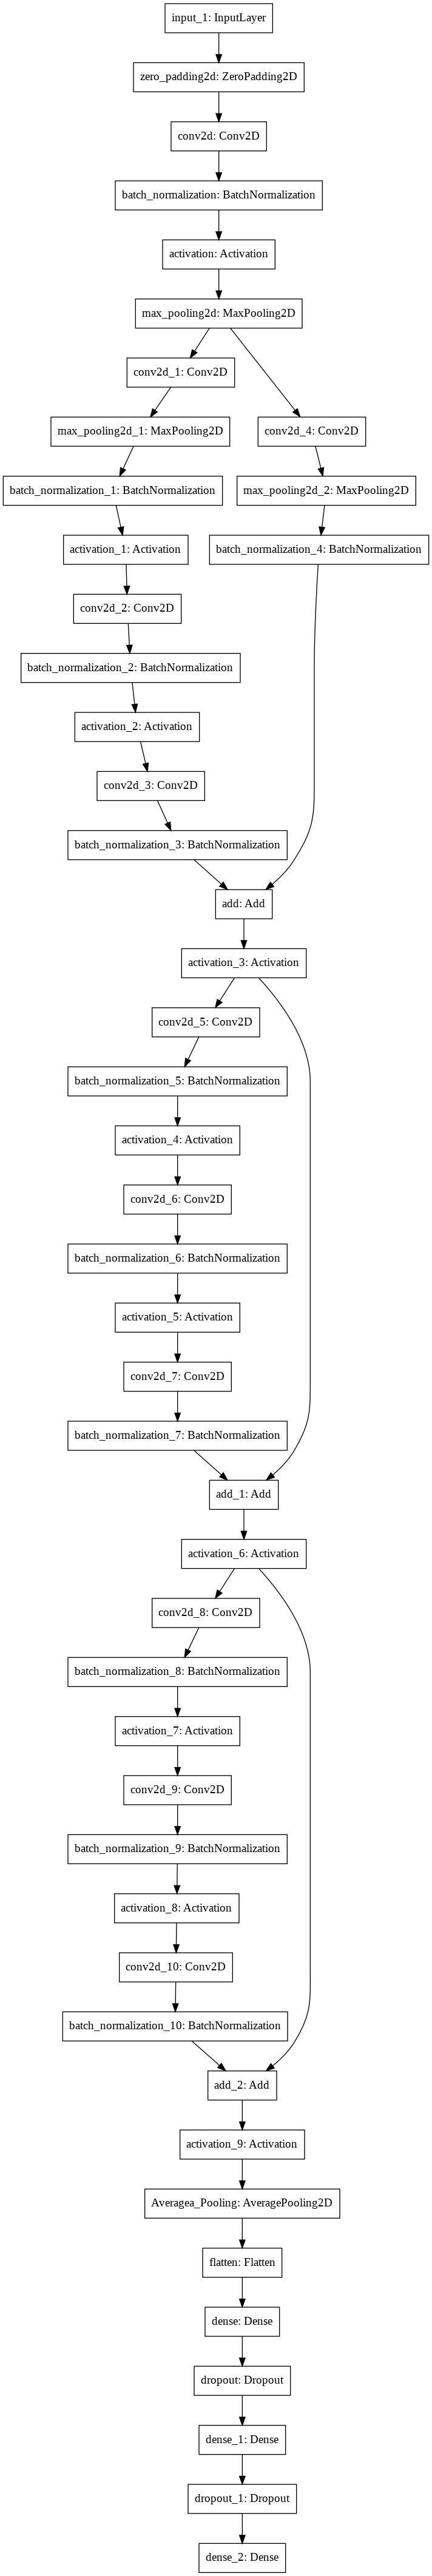

In [ ]:
plot_model(model,to_file="model1.png")

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

### Entrenamiento del modelo:

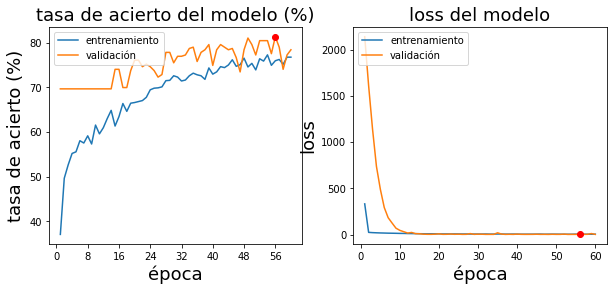

In [ ]:
epochs = 60
modelpath="best_model1.h5"

#checkpoint = ModelCheckpoint(filepath = "best_model.h5", verbose = 1, save_best_only = True)
checkpoint = ModelCheckpoint(filepath = "best_model1.h5", verbose = 1, save_best_only = True)

callbacks_list = [checkpoint]

acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

for e in range(epochs):

    history = model.fit(X_train, y_train, batch_size = 32, epochs = 1, validation_split = 0.2, callbacks=[checkpoint])
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

### Predicción del modelo (Train y test)

In [ ]:
modelo = load_model("best_model1.h5")

In [ ]:
y_predict_test = modelo.predict(X_test)
y_predict_train = modelo.predict(X_train)
print("MSE train: " + str(mean_squared_error(y_train, y_predict_train)))
print("MSE test: " + str(mean_squared_error(y_test, y_predict_test)))

print("MAE train: " + str(mean_absolute_error(y_train, y_predict_train)))
print("MAE test: " + str(mean_absolute_error(y_test, y_predict_test)))

print("r2_score train: " + str(r2_score(y_train, y_predict_train)))
print("r2_score test: " + str(r2_score(y_test, y_predict_test)))

print("Std train: " + str(np.std(y_train)))
print("Std test: " + str(np.std(y_test)))

MSE train: 2.4105558
MSE test: 3.8331451
MAE train: 1.1379858
MAE test: 1.3760587
r2_score train: 0.7433361733703024
r2_score test: 0.5986730591575281
Std train: 18.834307
Std test: 18.80153


#### Visualización de muestras de test:

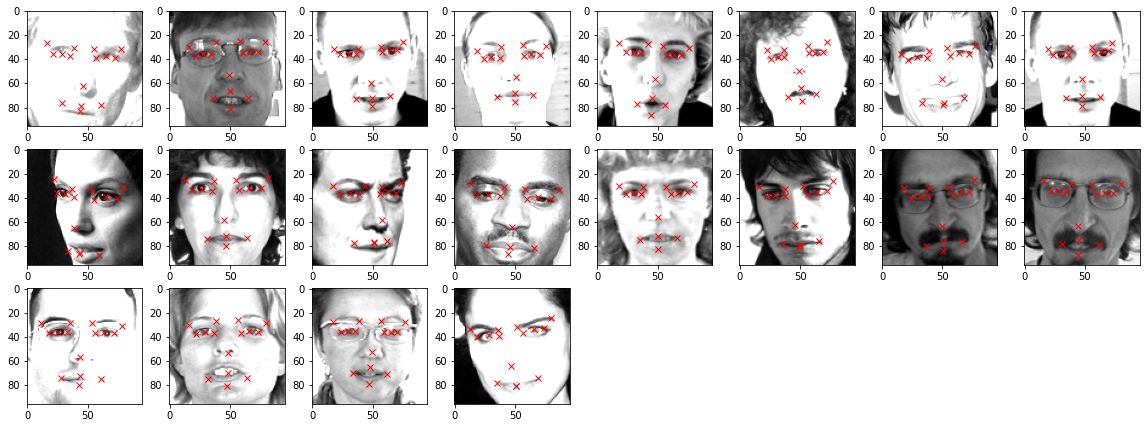

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i in range(20):
  ax = fig.add_subplot(8, 8, i + 1)  
  image = plt.imshow(X_test[i,:,:].reshape(96,96), cmap="gray")
  for j in range(1,31,2):
          plt.plot(y_predict_test[i][j-1], y_predict_test[i][j], 'rx')

## B) Modelo con 2 bloques Residuales

### Definición del modelo:

In [ ]:
input_shape = (96, 96, 1)

# Tamaño del tensor de entrada
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - Fase
X = Conv2D(64, (7,7), strides= (2,2))(X)
X = BatchNormalization(axis =3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

#Residual block 1
X = res_block(X, filter= [64,64,256], stage= 2)

# Residual block 2
X = res_block(X, filter= [128,128,512], stage= 3)

# Average Pooling
X = AveragePooling2D((2,2))(X)

# Capa Final
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 102, 102, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 48, 48, 64)   3200        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 48, 48, 64)   256         conv2d_53[0][0]                  
____________________________________________________________________________________________

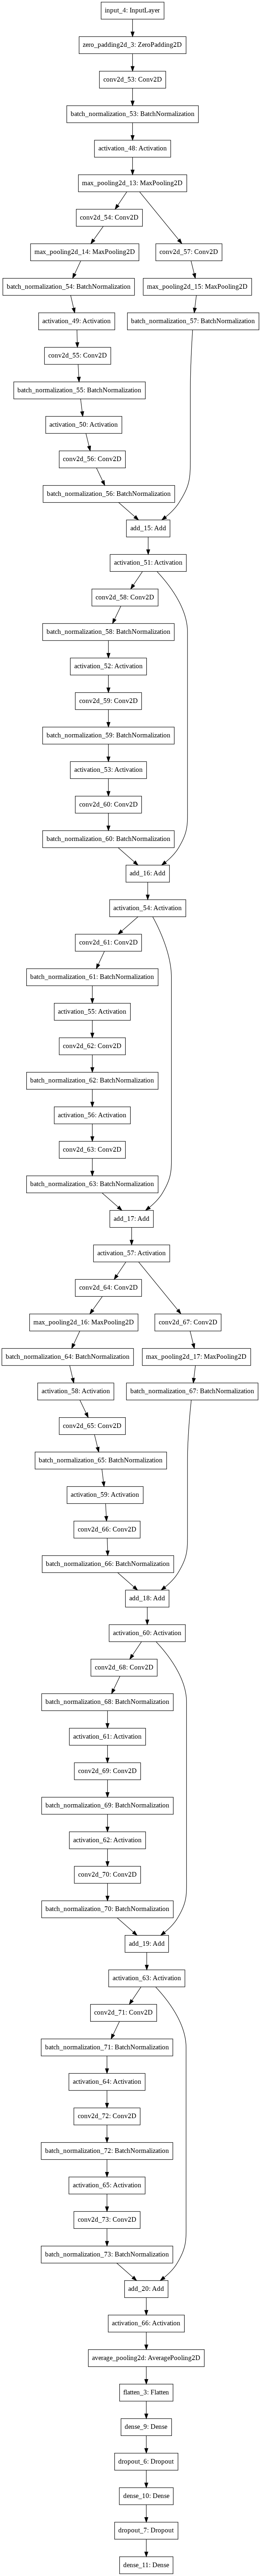

In [ ]:
plot_model(model,to_file="model2.png")

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

### Entrenamiento del modelo:

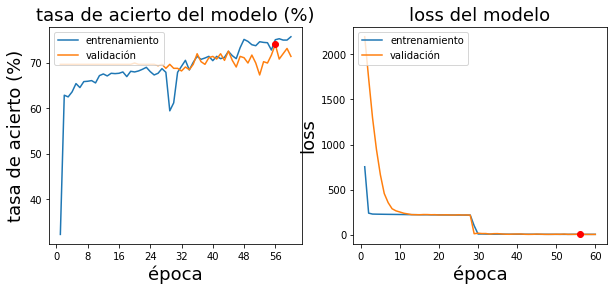

In [ ]:
epochs = 60
modelpath="best_model2.h5"

#checkpoint = ModelCheckpoint(filepath = "best_model.h5", verbose = 1, save_best_only = True)
checkpoint = ModelCheckpoint(filepath = "best_model2.h5", verbose = 1, save_best_only = True)

callbacks_list = [checkpoint]

acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

for e in range(epochs):

    history = model.fit(X_train, y_train, batch_size = 32, epochs = 1, validation_split = 0.2, callbacks=[checkpoint])
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

### Predicción del modelo (train y test)

In [ ]:
modelo = load_model("best_model2.h5")

In [ ]:
y_predict_test = modelo.predict(X_test)
y_predict_train = modelo.predict(X_train)
print("MSE train: " + str(mean_squared_error(y_train, y_predict_train)))
print("MSE test: " + str(mean_squared_error(y_test, y_predict_test)))

print("MAE train: " + str(mean_absolute_error(y_train, y_predict_train)))
print("MAE test: " + str(mean_absolute_error(y_test, y_predict_test)))

print("r2_score train: " + str(r2_score(y_train, y_predict_train)))
print("r2_score test: " + str(r2_score(y_test, y_predict_test)))

print("Std train: " + str(np.std(y_train)))
print("Std test: " + str(np.std(y_test)))

MSE train: 2.884639
MSE test: 5.389453
MAE train: 1.2542346
MAE test: 1.6470138
r2_score train: 0.6910761955959488
r2_score test: 0.43798460720584304
Std train: 18.834307
Std test: 18.80153


#### Visualización de muestras de test

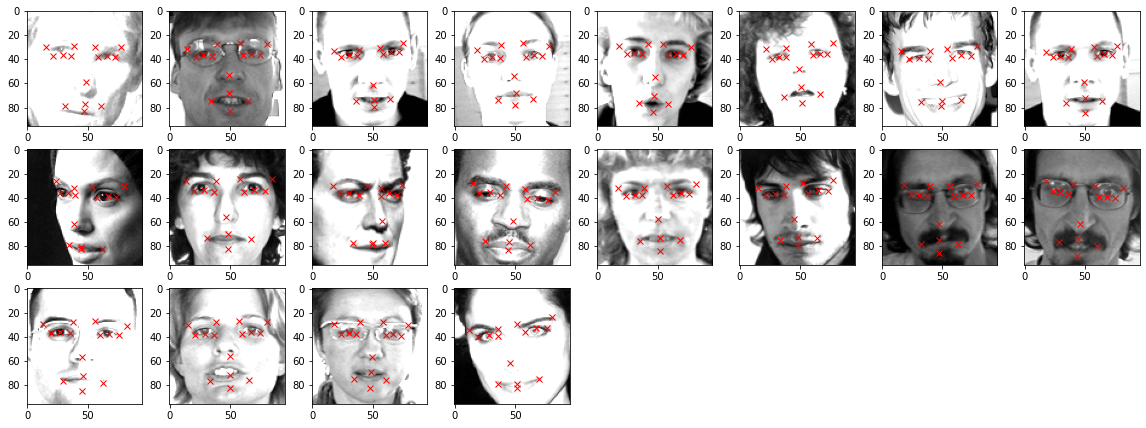

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i in range(20):
  ax = fig.add_subplot(8, 8, i + 1)  
  image = plt.imshow(X_test[i,:,:].reshape(96,96), cmap="gray")
  for j in range(1,31,2):
          plt.plot(y_predict_test[i][j-1], y_predict_test[i][j], 'rx')

# 2. Detección de puntos clave en tronco superior (imágenes con 3 canales)

### Preprocesado de los datos

**NOTA: Este código se ha ejecutado en local**

In [ ]:
size_final = [224,224]

pathSave = "/Users/quiquegarciavidal/Desktop/imagesKeypoint/imagenes/"

lista_keypoints = []
contador = 0
for set_ in tqdm(["set_a","set_b"]):
    _, _, filenames = next(walk(f"/Users/quiquegarciavidal/Desktop/shped_v01/rect_and_det/{set_}/annotations_joints/"))
    for file in filenames:
        path = f"/Users/quiquegarciavidal/Desktop/shped_v01/rect_and_det/{set_}/annotations_joints/{file}"
        mat = scipy.io.loadmat(path)
        
        listFolder = path.split("/")
        folder1 = listFolder[6]
        folder2 = listFolder[-1].split(".")[0][:-2]
        
        for x in range(len(mat["piw_data"][0])):
            points = mat["piw_data"][0][x][2]
            scores = mat["piw_data"][0][x][3]
            imageName = mat["piw_data"][0][x][1][0]
            #print(imageName)
            img = cv2.imread(f"/Users/quiquegarciavidal/Desktop/shped_v01/rect_and_det/{folder1}/{folder2}/{imageName}",cv.COLOR_BGR2RGB)
            listaPuntos = []
            size_inicio = img.shape
            
            for i in points:
                coordenada = new_coordinates_after_resize_img([size_inicio[1],size_inicio[0]], size_final, i)
                listaPuntos.append([coordenada[0],coordenada[1]])
                
            flat_list = [item for sublist in listaPuntos for item in sublist]
            print(flat_list)
            flat_list.append(str(contador))
            lista_keypoints.append(flat_list)
            img = cv.resize(img, (size_final[0],size_final[1]), interpolation = cv.INTER_AREA)
            cv.imwrite(pathSave+str(contador)+".jpg", img)
            contador += 1
            for i in listaPuntos:
                cv2.drawMarker(img,(int(i[0]),int(i[1])),(0, 0,255), markerType=cv.MARKER_CROSS, 
                        markerSize=40, thickness=2, line_type=cv.LINE_AA)

            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            plt.show()
datasetKeypoints = pd.DataFrame(lista_keypoints)
datasetKeypoints.to_excel("/Users/quiquegarciavidal/Desktop/imagesKeypoint/keypoints/keypoints.xlsx", index=False)

### Lectura, importación y preparación de los datos

In [ ]:
df = pd.read_excel("keypoints.xlsx")
y = df.iloc[:,:-1]

In [ ]:
f = []
for (dirpath, dirnames, filenames) in walk("/content/drive/MyDrive/TRABAJO/imagenes/"):
    f.extend(filenames)
    break
f.sort()

In [ ]:
X = []
y = []
for i in tqdm(f):
    img = cv.imread(f"/content/drive/MyDrive/TRABAJO/imagenes/{i}",cv.COLOR_BGR2RGB)
    row = int(i.split(".")[0])
    #print(i)
    y.append(np.array(df[df.iloc[:,16] == row].iloc[:,:-1])[0].tolist())
    img = img/255.
    X.append(img)
y_train = np.asarray(y).astype(np.float32)
X_train = np.asarray(X).astype(np.float32)

100%|██████████| 1470/1470 [07:26<00:00,  3.29it/s]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

#### Visualización de una imagen del conjunto de train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


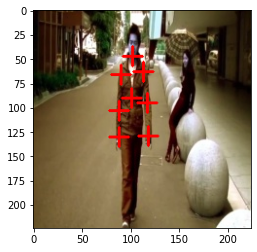

In [ ]:
def plot_imagen(X,y,selector_imagen):
  img = cv.cvtColor(X[selector_imagen], cv.COLOR_BGR2RGB)
  for i in range(0,16,2):
          cv.drawMarker(img,(int(y[selector_imagen][i]),int(y[selector_imagen][i+1])),(0, 0,255), markerType=cv.MARKER_CROSS, 
          markerSize=20, thickness=2, line_type=cv.LINE_AA);
  plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));
  plt.show();

selector_imagen = 340
plot_imagen(X_train,y_train,selector_imagen)

### A) Modelo ResNet (transfer learning) modificado

In [ ]:
model = keras.Sequential(hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",trainable=False,input_shape=(224,224,3)))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='linear'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

In [ ]:
adam = tf.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

#### Entrenamiento del modelo

In [ ]:
def grafica_entrenamiento2(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    plt.show()

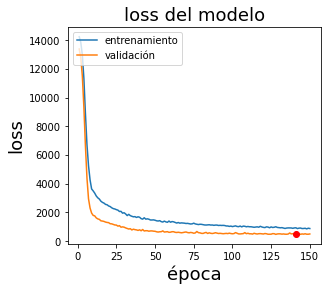

In [ ]:
epochs = 150
modelpath="resnet.h5"

#checkpoint = ModelCheckpoint(filepath = "best_model.h5", verbose = 1, save_best_only = True)
checkpoint = ModelCheckpoint(filepath = "resnet.h5", verbose = 1, save_best_only = True)

callbacks_list = [checkpoint]

acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

for e in range(epochs):

    history = model.fit(X_train, y_train, batch_size = 64, epochs = 1, validation_split = 0.3, callbacks=[checkpoint])
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento2(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

#### Prediccion

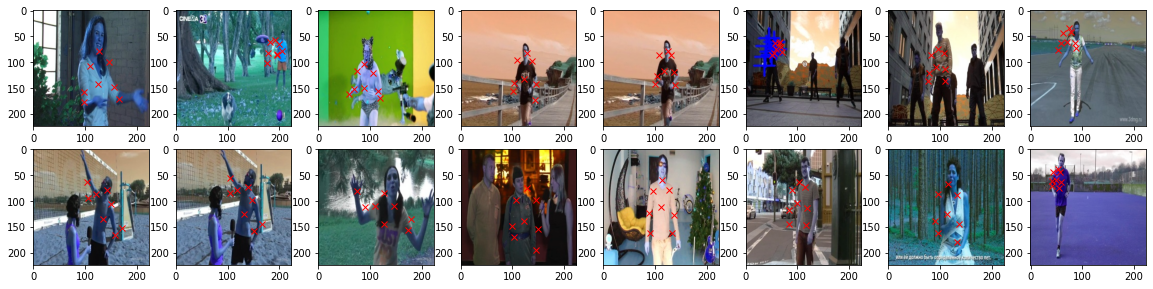

In [ ]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

fig = plt.figure(figsize=(20, 20))
for i in range(16):
  ax = fig.add_subplot(8, 8, i + 1)  
  image = plt.imshow(X_test[i,:,:], cmap="gray")
  for j in range(1,17,2):
          plt.plot(y_test_predict[i][j-1], y_test_predict[i][j], 'rx')

In [ ]:
print("MSE train: " + str(mean_squared_error(y_train, y_train_predict)))
print("MSE test: " + str(mean_squared_error(y_test, y_test_predict)))

print("MAE train: " + str(mean_absolute_error(y_train, y_train_predict)))
print("MAE test: " + str(mean_absolute_error(y_test, y_test_predict)))

print("r2_score train: " + str(r2_score(y_train, y_train_predict)))
print("r2_score test: " + str(r2_score(y_test, y_test_predict)))

print("Std train: " + str(np.std(y_train)))
print("Std test: " + str(np.std(y_test)))

MSE train: 463.4629
MSE test: 615.7159
MAE train: 13.9224205
MAE test: 15.759432
r2_score train: 0.7167363446730746
r2_score test: 0.6075640392503066
Std train: 44.452335
Std test: 44.16769


### B) Modelo PoseNet (transfer learning con MobileNet)

In [ ]:
model = keras.Sequential(hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",trainable=False,input_shape=(224,224,3)))
#input = Input(shape=(224,224,3))
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2048, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_22 (Dense)             (None, 4096)              5246976   
_________________________________________________________________
dropout_16 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_17 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)             

In [ ]:
adam = tf.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

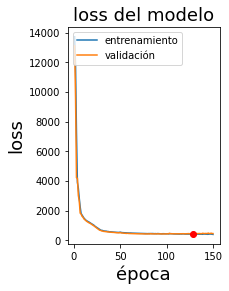

In [ ]:
epochs = 150
modelpath="mobilenet.h5"

#checkpoint = ModelCheckpoint(filepath = "best_model.h5", verbose = 1, save_best_only = True)
checkpoint = ModelCheckpoint(filepath = "mobilenet.h5", verbose = 1, save_best_only = True)

callbacks_list = [checkpoint]

acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

for e in range(epochs):

    history = model.fit(X_train, y_train, batch_size = 128, epochs = 1, validation_split = 0.4, callbacks=callbacks_list)
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento2(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

#### Prediccion

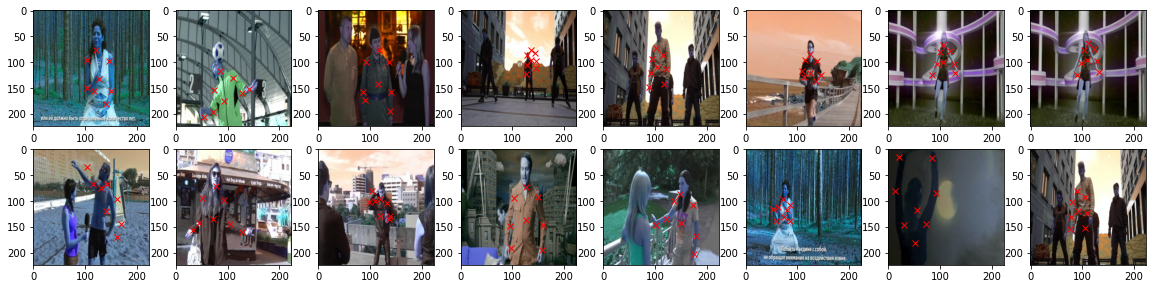

In [ ]:
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

fig = plt.figure(figsize=(20, 20))
for i in range(16):
  ax = fig.add_subplot(8, 8, i + 1)  
  image = plt.imshow(X_test[i,:,:], cmap="gray")
  for j in range(1,17,2):
          plt.plot(y_test_predict[i][j-1], y_test_predict[i][j], 'rx')

In [ ]:

print("MSE train: " + str(mean_squared_error(y_train, y_train_predict)))
print("MSE test: " + str(mean_squared_error(y_test, y_test_predict)))

print("MAE train: " + str(mean_absolute_error(y_train, y_train_predict)))
print("MAE test: " + str(mean_absolute_error(y_test, y_test_predict)))

print("r2_score train: " + str(r2_score(y_train, y_train_predict)))
print("r2_score test: " + str(r2_score(y_test, y_test_predict)))

print("Std train: " + str(np.std(y_train)))
print("Std test: " + str(np.std(y_test)))

MSE train: 390.31998
MSE test: 474.24103
MAE train: 9.860411
MAE test: 11.122808
r2_score train: 0.7629074152002198
r2_score test: 0.7382392722619728
Std train: 44.240356
Std test: 44.99201


#3. Detección de puntos clave en cuerpo completo (video)

## A) Aplicando modelo preentrenados: 

### Importar el modelo (local):

In [ ]:
net = cv.dnn.readNetFromTensorflow("/Users/quiquegarciavidal/Desktop/pose/graph_opt.pb") 

### Definición de variables:

In [ ]:
inWidth = 368
inHeight = 368
thr = 0.2

BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

### Ejecución modelo sobre vídeo (webcam)

**NOTA: La ejecución de este código debe hacerse en local, pues desde colab no se puede acceder a la cámara**

In [ ]:
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)

if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    input_net = cv.dnn.blobFromImage(frame,1.0,(inWidth, inHeight),(127.5,127.5,127.5),swapRB=True, crop=False)
    #print(input_net.shape)
    net.setInput(input_net)
    out = net.forward()
    #print(out.shape)
    out = out[:, :19, :, :]
    #print(out.shape)
    
    points = []
    
    for i in range(len(BODY_PARTS)):
        
        heatMap = out[0, i, :, :]
        
        _, conf, _,point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        
         #Devuelve lista con una tupla en cada posición, donde la tupla es x,y de cada punto del cuerpo
        points.append((int(x),int(y)) if conf > thr else None) 
       
    
    #Selecciona, para cada elemento del cuerpo, la posicion en la lista para unir puntos:
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        #Si tanto idFrom como idTo encuentra los puntos, entonces pinta la linea
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0,255,0), 3)
            cv.ellipse(frame, points[idFrom], (3,3), 0, 0, 360, (0,0,255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3,3), 0, 0, 360, (0, 0, 255), cv.FILLED)
    
    #t, _ = net.getPerfProfile()
    #freq = cv.getTickFrequency() / 1000
    #cv.putText(frame, '%.2fms' % (t / freq), (10,20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    cv.imshow("Estimación de la postura: ", frame)
    

## B) Aplicando modelos preentrenados: Centernet.

### Importar modelo (Tensorflow Hub)

In [ ]:
hub_model = hub.load("https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1")

### Definición de variables:

In [ ]:
threshold = 0.4

### Ejecución modelo sobre vídeo (webcam)

**NOTA: La ejecución de este código debe hacerse en local, pues desde colab no se puede acceder a la cámara**

In [ ]:
cap = cv.VideoCapture(1)


cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)

if not cap.isOpened():
    raise IOError("No se ha podido abrir la webcam")

while cv.waitKey(1) < 0:
    hasFrame, img = cap.read()
    img2 = img
    
    image_np = np.array([cv.resize(img, (512,512), interpolation = cv.INTER_AREA)])
    
    results = hub_model(image_np)
    keypoints = results["detection_keypoints"][0][0].numpy()
    keypointsScore = results["detection_keypoint_scores"][0][0].numpy()
    
    size = img.shape
    lenX = size[0]
    lenY = size[1]
    
    keypoints_ = [(int(x[1]*lenY),int(x[0]*lenX)) for x in keypoints]
    
     #LINE A
    if keypointsScore[0] > threshold and  keypointsScore[1] > threshold:
        cv.line(img, keypoints_[0], keypoints_[1], (0,255,0), 3)
    #LINE B
    if keypointsScore[0] > threshold and  keypointsScore[2] > threshold:
        cv.line(img, keypoints_[0], keypoints_[2], (0,255,0), 3)
    #LINE C
    if keypointsScore[2] > threshold and  keypointsScore[4] > threshold:
        cv.line(img, keypoints_[2], keypoints_[4], (0,255,0), 3)
    #LINE D
    if keypointsScore[1] > threshold and  keypointsScore[3] > threshold:
        cv.line(img, keypoints_[1], keypoints_[3], (0,255,0), 3)        
    #LINE E
    if keypointsScore[5] > threshold and  keypointsScore[7] > threshold:
        cv.line(img, keypoints_[5], keypoints_[7], (0,255,0), 3)       
    #LINE F
    if keypointsScore[6] > threshold and  keypointsScore[8] > threshold:
        cv.line(img, keypoints_[6], keypoints_[8], (0,255,0), 3)       
    #LINE G
    if keypointsScore[7] > threshold and  keypointsScore[9] > threshold:
        cv.line(img, keypoints_[7], keypoints_[9], (0,255,0), 3)       
    #LINE H
    if keypointsScore[8] > threshold and  keypointsScore[10] > threshold:
        cv.line(img, keypoints_[8], keypoints_[10], (0,255,0), 3)       
    #LINE J
    if keypointsScore[6] > threshold and  keypointsScore[5] > threshold:
        cv.line(img, keypoints_[6], keypoints_[5], (0,255,0), 3) 
    #LINE K 
    if keypointsScore[12] > threshold and  keypointsScore[11] > threshold:
        cv.line(img, keypoints_[12], keypoints_[11], (0,255,0), 3)   
    #LINE L
    if keypointsScore[11] > threshold and  keypointsScore[13] > threshold:
        cv.line(img, keypoints_[11], keypoints_[13], (0,255,0), 3)   
    #LINE M
    if keypointsScore[12] > threshold and  keypointsScore[14] > threshold:
        cv.line(img, keypoints_[12], keypoints_[14], (0,255,0), 3)   
    #LINE N
    if keypointsScore[13] > threshold and  keypointsScore[15] > threshold:
        cv.line(img, keypoints_[13], keypoints_[15], (0,255,0), 3)   
    #LINE O
    if keypointsScore[14] > threshold and  keypointsScore[16] > threshold:
        cv.line(img, keypoints_[14], keypoints_[16], (0,255,0), 3) 
    
    #LINE I
    if keypointsScore[0] > threshold and keypointsScore[12] > threshold and  keypointsScore[11] > threshold:
        point1 = (int(keypoints_[6][0] + abs(keypoints_[12][0] - keypoints_[11][0])/2),int(abs(keypoints_[12][1] + keypoints_[11][1])/2))
        cv.line(img, keypoints_[0], point1, (0,255,0), 3) 
        
    for i in range(len(keypoints)):
        if keypointsScore[i] >= threshold:
          cv.drawMarker(img,(keypoints_[i][0],keypoints_[i][1]),(0,0,255), markerType=cv.MARKER_CROSS, 
            markerSize=40, thickness=2, line_type=cv.LINE_AA)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    cv.imshow("Estimacion de la pose ", img)
    